<a href="https://colab.research.google.com/github/justineMD2002/bruno_testing/blob/main/bruno_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install nltk rouge-score bert-score scikit-learn seaborn matplotlib pandas requests kagglehub sentence-transformers

In [ ]:
import time
import warnings
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import kagglehub
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
from bert_score import score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer, util

warnings.filterwarnings("ignore")

API_URL = "https://api-rag.nicetree-cb812374.westus2.azurecontainerapps.io/ask"

def chatbot_api(question):
    payload = {"prompt": question}
    response = requests.post(API_URL, json=payload)
    if response.status_code == 200:
        return response.json()
    else:
        return {
            "response": "Error: Unable to get a response from the API.",
            "response_time": None
        }

path = kagglehub.dataset_download("stackoverflow/stacksample")

DATASET_PATH = path
questions_df = pd.read_csv(f"{DATASET_PATH}/Questions.csv", encoding="ISO-8859-1")
answers_df = pd.read_csv(f"{DATASET_PATH}/Answers.csv", encoding="ISO-8859-1")

merged_df = questions_df.merge(answers_df, left_on='Id', right_on='ParentId', suffixes=('_q', '_a'))

merged_df = merged_df.sort_values(['ParentId', 'Score_a'], ascending=[True, False])
merged_df = merged_df.drop_duplicates(subset=['ParentId'], keep='first')

model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

In [ ]:
test_data = list(zip(merged_df['Title'] + " " + merged_df['Body_q'], merged_df['Body_a']))[:1000]

In [ ]:
def evaluate_chatbot(chatbot_function):
    precision_list, recall_list = [], []
    bleu_scores, rouge1_scores, rouge2_scores, rougeL_scores, bert_scores, response_times = [], [], [], [], [], []
    semantic_similarity_scores = []

    for question, reference in test_data:
        result = chatbot_function(question)
        chatbot_response = result["response"]
        response_time = result["response_time"]

        print(f"\nPrompt: {question}")
        print(f"Model Response: {chatbot_response}")
        print(f"Reference Answer: {reference}\n")

        smoothie = SmoothingFunction().method1
        bleu = sentence_bleu([reference.split()], chatbot_response.split(), smoothing_function=smoothie)

        scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
        rouge_scores = scorer.score(reference, chatbot_response)

        P, R, F1 = score([chatbot_response], [reference], lang="en", model_type="bert-base-uncased")
        bert_f1 = F1.mean().item()

        true_labels = [1]
        retrieved_labels = [1 if len(set(reference.split()) & set(chatbot_response.split())) > 0 else 0]
        precision = precision_score(true_labels, retrieved_labels, zero_division=1)
        recall = recall_score(true_labels, retrieved_labels, zero_division=1)
        precision_list.append(precision)
        recall_list.append(recall)

        embeddings = model.encode([chatbot_response, reference])

        similarity_score = cosine_similarity([embeddings[0]], [embeddings[1]])[0][0]
        semantic_similarity_scores.append(similarity_score)

        bleu_scores.append(bleu)
        rouge1_scores.append(rouge_scores['rouge1'].fmeasure)
        rouge2_scores.append(rouge_scores['rouge2'].fmeasure)
        rougeL_scores.append(rouge_scores['rougeL'].fmeasure)
        bert_scores.append(bert_f1)
        response_times.append(response_time)

    avg_bleu = sum(bleu_scores) / len(bleu_scores)
    avg_rouge1 = sum(rouge1_scores) / len(rouge1_scores)
    avg_rouge2 = sum(rouge2_scores) / len(rouge2_scores)
    avg_rougeL = sum(rougeL_scores) / len(rougeL_scores)
    avg_bert = sum(bert_scores) / len(bert_scores)
    avg_response_time = sum(response_times) / len(response_times)
    avg_precision = sum(precision_list) / len(precision_list)
    avg_recall = sum(recall_list) / len(recall_list)
    avg_semantic_similarity = sum(semantic_similarity_scores) / len(semantic_similarity_scores)

    metrics = ['BLEU', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'BERTScore F1', 'Precision', 'Recall', 'Semantic Similarity']
    avg_scores = [avg_bleu, avg_rouge1, avg_rouge2, avg_rougeL, avg_bert, avg_precision, avg_recall, avg_semantic_similarity]

    plt.figure(figsize=(12, 6))
    sns.barplot(x=metrics, y=avg_scores, palette="viridis")
    plt.title("Chatbot Evaluation Summary (Excluding Response Time)")
    plt.ylabel("Score")
    plt.xticks(rotation=45)
    plt.show()

    response_time_metrics = ['Response Time']
    response_time_scores = [avg_response_time]

    plt.figure(figsize=(6, 6))
    sns.barplot(x=response_time_metrics, y=response_time_scores, palette="Blues")
    plt.title("Chatbot Response Time (Milliseconds)")
    plt.ylabel("Time (ms)")
    plt.show()

    return {
        "Average BLEU": avg_bleu,
        "Average ROUGE-1": avg_rouge1,
        "Average ROUGE-2": avg_rouge2,
        "Average ROUGE-L": avg_rougeL,
        "Average BERTScore F1": avg_bert,
        "Average Response Time": avg_response_time,
        "Average Precision": avg_precision,
        "Average Recall": avg_recall,
        "Average Semantic Similarity": avg_semantic_similarity
    }


Prompt: SQLStatement.execute() - multiple queries in one statement <p>I've written a database generation script in <a href="http://en.wikipedia.org/wiki/SQL">SQL</a> and want to execute it in my <a href="http://en.wikipedia.org/wiki/Adobe_Integrated_Runtime">Adobe AIR</a> application:</p>

<pre><code>Create Table tRole (
      roleID integer Primary Key
      ,roleName varchar(40)
);
Create Table tFile (
    fileID integer Primary Key
    ,fileName varchar(50)
    ,fileDescription varchar(500)
    ,thumbnailID integer
    ,fileFormatID integer
    ,categoryID integer
    ,isFavorite boolean
    ,dateAdded date
    ,globalAccessCount integer
    ,lastAccessTime date
    ,downloadComplete boolean
    ,isNew boolean
    ,isSpotlight boolean
    ,duration varchar(30)
);
Create Table tCategory (
    categoryID integer Primary Key
    ,categoryName varchar(50)
    ,parent_categoryID integer
);
...
</code></pre>

<p>I execute this in Adobe AIR using the following methods:</p>

<pre><code>pub

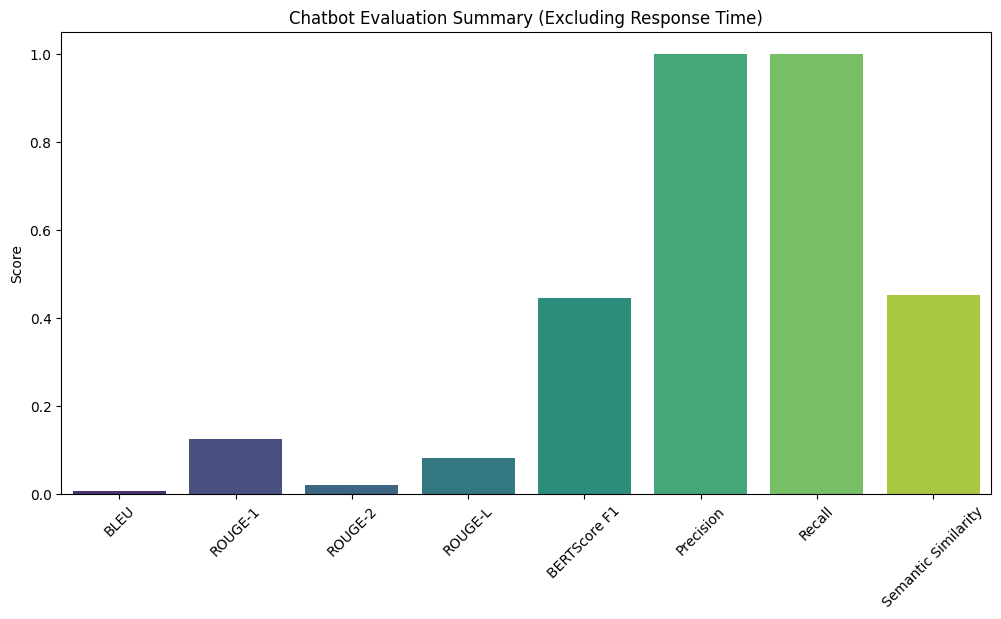

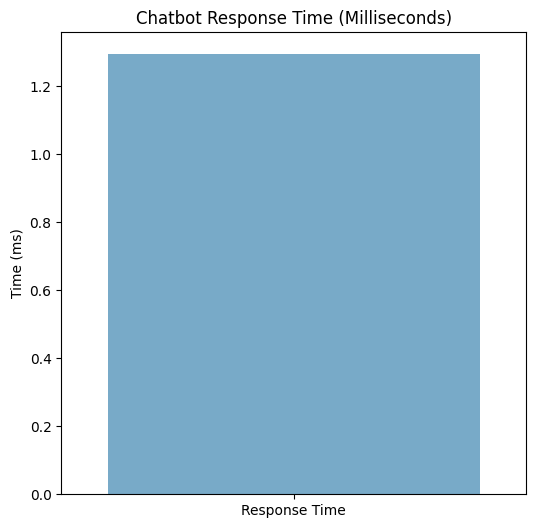

In [ ]:
evaluation_summary = evaluate_chatbot(chatbot_api)

In [ ]:
for key, value in evaluation_summary.items():
    print(f"{key}: {value}")

Average BLEU: 0.0061165765462735285
Average ROUGE-1: 0.1251708479275547
Average ROUGE-2: 0.019454079324385462
Average ROUGE-L: 0.08075056246502438
Average BERTScore F1: 0.4455752372741699
Average Response Time: 1.2932499249776204
Average Precision: 1.0
Average Recall: 1.0
Average Semantic Similarity: 0.4524441659450531
